In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, HdpModel
from gensim.models.phrases import Phraser
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud
import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [3]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [4]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

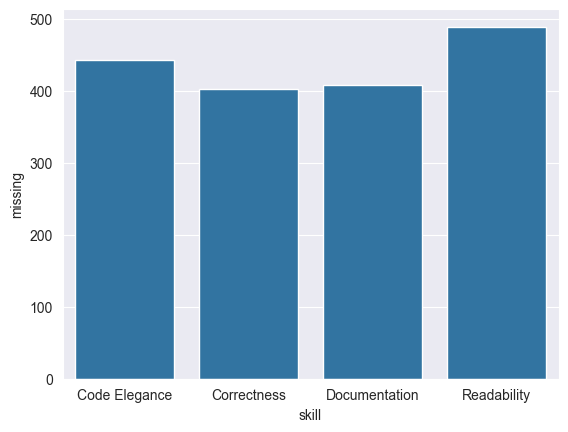

In [5]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [6]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [7]:
stopwords = nltk.corpus.stopwords.words('english')

def process_comments(comments):
    comments = comments.lower()
    comments = comments.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    tokens = nltk.word_tokenize(comments)
    
    tokens = [w for w in tokens if w not in stopwords]

    return tokens

In [8]:
nlp_df['tokens'] = nlp_df['comments'].apply(process_comments)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org..."
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth..."
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented..."
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,..."
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,..."
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ..."
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]"
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha..."
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le..."


### Sentiment

In [9]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...",True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...",True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...",True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...",True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...",True
...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...",False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]",False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...",True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...",True


In [10]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


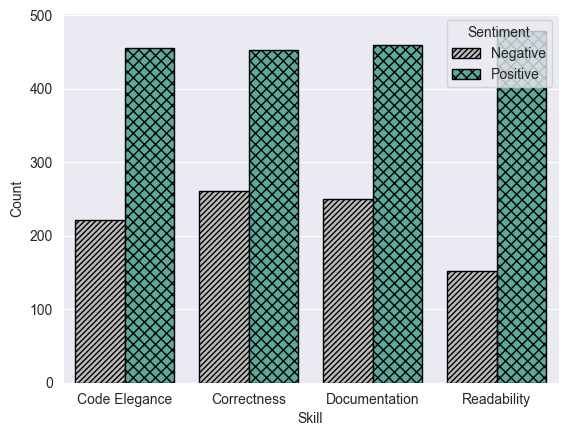

In [12]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [13]:
text_data = [token for token_list in nlp_df[nlp_df['skill'] == 'Readability']['tokens'].to_list() for token in token_list]
text_data[:10]

['code',
 'use',
 'meaningful',
 'identifier',
 'names',
 'organized',
 'way',
 'makes',
 'logical',
 'flow']

In [14]:
bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[text_data], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [15]:
def process_words(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [16]:
# TODO: Build LDA for correctness, readability and maintainability

In [17]:
processed_text = process_words(text_data)
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(text) for text in processed_text]



In [18]:
def generate_topic_models(corpus, dictionary, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [19]:
models = {}
coherence_results = []

for topic_count in tqdm([1, 2, 4, 5, 10, 15, 20, 30]):
    model, coherence = generate_topic_models(corpus, dictionary, topic_count)
    models[str(topic_count)] = model
    coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
    
coherence_df = pd.DataFrame(coherence_results)
coherence_df.head()

,topic_count,coherence
0,1,-23.676866
1,2,-23.169084
2,4,-22.447508
3,5,-22.006652
4,10,-21.893197


<Axes: xlabel='topic_count', ylabel='coherence'>

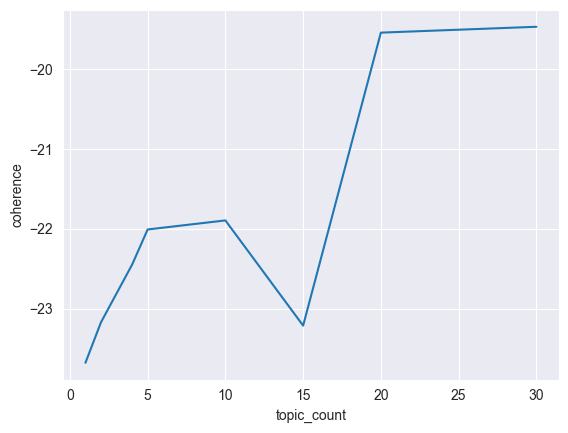

In [20]:
sns.lineplot(coherence_df, x='topic_count', y='coherence')

In [21]:
topic_count = '4'
vis = pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.152311 -0.326912       1        1  27.061226
1      0.133034  0.263396       2        1  25.417813
3     -0.379774 -0.018460       3        1  24.680281
2      0.094430  0.081976       4        1  22.840681, topic_info=             Term        Freq       Total Category  logprob  loglift
1             use  450.000000  450.000000  Default  30.0000  30.0000
4            name  344.000000  344.000000  Default  29.0000  29.0000
19       variable  353.000000  353.000000  Default  28.0000  28.0000
0            code  297.000000  297.000000  Default  27.0000  27.0000
38           good  291.000000  291.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
472   significant   16.804929   18.874943   Topic4  -4.3117   1.3605
473        amount   16.802480   18.875210   Topic4  -4.3118   1.3603
474      instance   17.474825   19.647393   Topic4  -4.2726   1.3594
470  unconvential   16.103501   18.139632   Topic4  -4.3543   1.3576
287   unnecessary   15.482906   17.436037   Topic4  -4.3936   1.3578

[162 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
469       1  0.059665    absolute
469       2  0.059665    absolute
469       4  0.894978    absolute
23        2  0.938318      access
459       4  0.940192  accurately
...     ...       ...         ...
1         1  0.998987         use
19        1  0.997107    variable
6         2  0.945673         way
61        4  0.954789        well
17        1  0.991067  whitespace

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

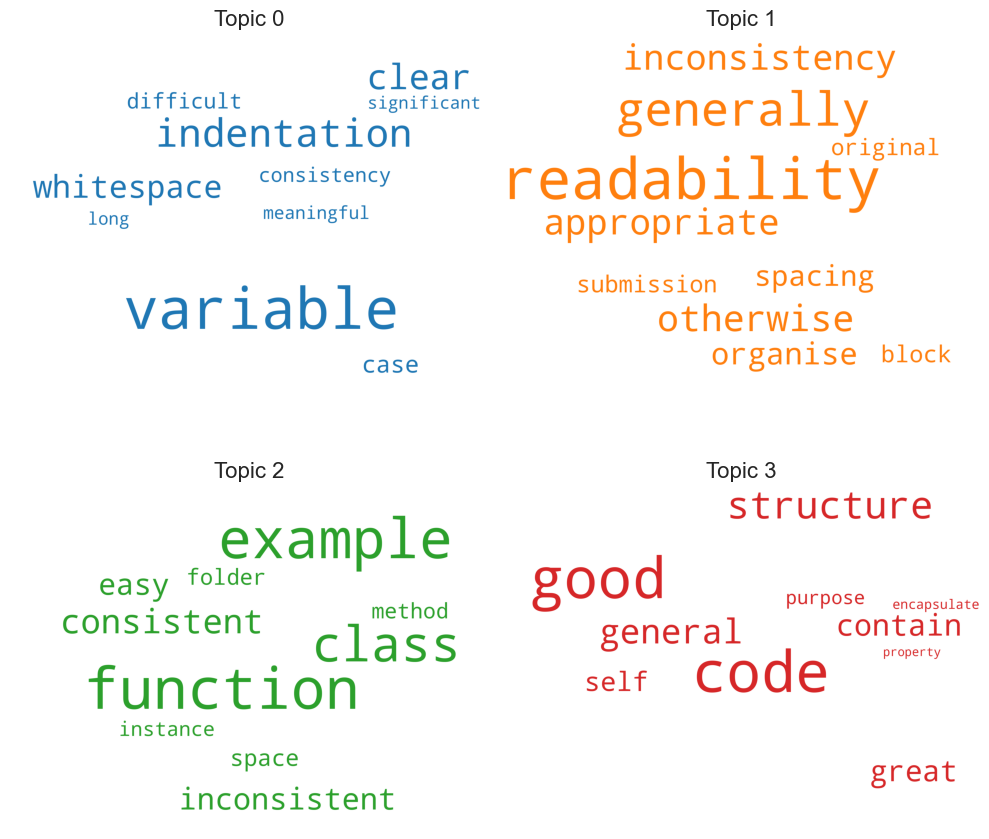

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = models['5'].show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()